In [250]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import datetime
import time

In [251]:
%matplotlib inline

In [252]:
Stock50_TWI = pd.read_csv('CAPM.csv',  encoding='cp950')
Stock50_TWI.rename(columns={'證券代碼':'code','簡稱':'firm','年月':'date','報酬率％_月':'rate'},inplace=True)
Stock50_TWI

,code,date,rate
0,1101 台泥,201901,4.9159
1,1216 統一,201901,3.0088
2,1301 台塑,201901,0.9901
3,1303 南亞,201901,1.0594
4,1326 台化,201901,1.4286
...,...,...,...
2137,6505 台塑化,202206,-1.0330
2138,8046 南電,202206,-5.7035
2139,8454 富邦媒,202206,-7.9041
2140,9910 豐泰,202206,0.7894


In [253]:
Stock50_TWI['code'] = Stock50_TWI['code'].apply(lambda x:x.strip())

In [254]:
def get_element(my_list, position):
    return my_list[position]

In [255]:
Stock50_TWI['name']=Stock50_TWI['code'].str.split(' ').apply(get_element, position=1)
Stock50_TWI['code']=Stock50_TWI['code'].str.split(' ').apply(get_element, position=0)

In [256]:
Stock50_TWI = Stock50_TWI.reindex(columns=['code','name','date','rate'])
Stock50_TWI

,code,name,date,rate
0,1101,台泥,201901,4.9159
1,1216,統一,201901,3.0088
2,1301,台塑,201901,0.9901
3,1303,南亞,201901,1.0594
4,1326,台化,201901,1.4286
...,...,...,...,...
2137,6505,台塑化,202206,-1.0330
2138,8046,南電,202206,-5.7035
2139,8454,富邦媒,202206,-7.9041
2140,9910,豐泰,202206,0.7894


# 整理 data 轉成 收盤價 time series
https://www.finlab.tw/python-%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E5%AF%A6%E4%BD%9C%EF%BC%81/

In [257]:
#data = Stock50_TWI.sort_values(by=['code', 'date']) #按照公司且日期由小到大排列

In [258]:
data = Stock50_TWI.set_index('date')
data['rate'] = data['rate'] - 0.83
data

,code,name,rate
date,,,
201901,1101,台泥,4.0859
201901,1216,統一,2.1788
201901,1301,台塑,0.1601
201901,1303,南亞,0.2294
201901,1326,台化,0.5986
...,...,...,...
202206,6505,台塑化,-1.8630
202206,8046,南電,-6.5335
202206,8454,富邦媒,-8.7341


In [259]:
# 提示
data.pivot_table(index=['date'],values=['rate'],columns=['code','name']) #透視表
data.query('code =="Y9999"') #顯示個股

,code,name,rate
date,,,
201901,Y9999,加權指數,1.2759
201902,Y9999,加權指數,3.7703
201903,Y9999,加權指數,1.5944
201904,Y9999,加權指數,2.2401
201905,Y9999,加權指數,-5.1084
201906,Y9999,加權指數,1.3831
201907,Y9999,加權指數,0.0365
201908,Y9999,加權指數,-2.7310
201909,Y9999,加權指數,1.1631


In [260]:
#資料比數有多少筆
data_num = len(data['code'].unique())-1
#取出公司代號
firm = data['code'].unique()
firm[50]

'Y9999'

In [261]:
x = data.query('code =="Y9999"')['rate'] 
X = sm.add_constant(x)
results_list =[]

#跑迴歸模型
for i in range(data_num):
    y = data.query('code == @firm[@i]')['rate'] 
    results = sm.OLS(y,X).fit()
    results_list.append({'res':results,
                        'code':firm[i]})
    
#將beta_alpha收集起來
beta_alpha = []
for i in range(data_num):
    beta_alpha .append({'code':firm[i],
        'beta':round(results_list[i]['res'].params.values[1],3),
        'jensens_alpha':round(results_list[i]['res'].params.values[0],3)})


D:\python\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [262]:
beta_alpha_df = pd.DataFrame(beta_alpha,columns=['code','jensens_alpha','beta'])

In [263]:
# 把超額市場報酬圖片給繪制出來
def getStockInfo(num):
    fig = plt.figure()
    alpha = beta_alpha_df[beta_alpha_df['code'] == num].values[0][1] #alpha
    beta  = beta_alpha_df[beta_alpha_df['code'] == num].values[0][2] #beta
    market_risk_premium = data.query('code =="Y9999"')['rate'] 
    x = market_risk_premium
    y = alpha + beta * market_risk_premium
    Ri_Rf = data.query('code =="Y9999"')['rate']
    Rm_Rf = data.query('code == @num')['rate']
    plt.scatter(Rm_Rf,Ri_Rf,c='red',alpha=0.8)
    plt.plot(x,y,c='black',label='SCL')
    plt.axhline(y=0,c='b')
    plt.axvline(x=0,c='b')
    plt.xlabel('E(Ri)-Rf')
    plt.ylabel('E(Rm)-Rf')
    plt.grid()

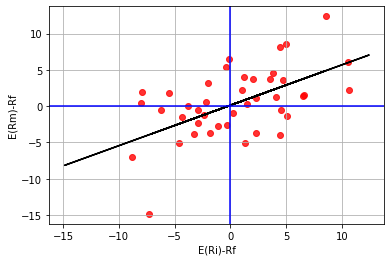

In [264]:
getStockInfo('1101')

In [265]:
# 各公司從201901-202206的平均報酬
sectors = Stock50_TWI.groupby('code')
mean_series = round(sectors['rate'].mean(),2)
mean_df = pd.DataFrame(mean_series)
mean_df.reset_index(inplace=True)
mean_df.rename(columns={'rate':'mean'},inplace=True) 
sol = pd.merge(beta_alpha_df,mean_df,how='left')
sol

,code,jensens_alpha,beta,mean
0,1101,0.127,0.558,1.26
1,1216,-0.868,0.363,0.16
2,1301,-0.650,0.824,0.63
3,1303,-0.594,1.001,0.79
4,1326,-1.389,0.835,-0.10
5,1590,1.795,1.494,3.45
6,2002,-0.110,1.172,1.37
7,2207,1.304,1.110,2.75
8,2303,2.903,1.544,4.59
9,2308,0.365,1.457,2.00


In [266]:
x_1 = sol['beta']
y_1 = sol['mean']
X_1 = sm.add_constant(x_1)
results = sm.OLS(y_1,X_1).fit()
print(results.params)
print(results.summary())
a=results.params[0]
b=results.params[1]

const   -0.620951
beta     2.862721
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     68.26
Date:                Wed, 08 Jun 2022   Prob (F-statistic):           8.88e-11
Time:                        16:39:00   Log-Likelihood:                -92.759
No. Observations:                  50   AIC:                             189.5
Df Residuals:                      48   BIC:                             193.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

D:\python\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# 畫圖

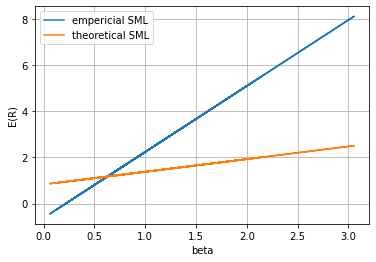

In [267]:
x_2 = sol['beta']
y_2 = a + b*x_2

X1 = sol['beta']
Y1 = 0.83 + (1.38-0.83) * sol['beta']

fig = plt.figure()
plt.plot(x_2,y_2,label='empericial SML')
plt.plot(X1,Y1,label='theoretical SML')
plt.xlabel('beta')
plt.ylabel('E(R)')
plt.grid()
plt.legend(loc='best')